<a href="https://www.kaggle.com/code/shreyashchacharkar/tep-fault-diagnosis-using-neural-networks?scriptVersionId=209580876" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
conda install tsnecuda -c conda-forge -q

done
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pyreadr -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
import tsnecuda

In [9]:
from tsnecuda import TSNE as TSNE_GPU

In [6]:
#import important liberies
import pandas as pd
import numpy as np

#visualisation liberies
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#.rdata file reader
import pyreadr

#sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

import sklearn

# Data preprocessing

In [8]:
# pyreadr converts rData into dictionary type object.
df_faulty_training = pyreadr.read_r("/kaggle/input/tennessee-eastman-process-simulation-dataset/TEP_Faulty_Training.RData")
df_fault_free_training = pyreadr.read_r("/kaggle/input/tennessee-eastman-process-simulation-dataset/TEP_FaultFree_Training.RData")
df_faulty_testing = pyreadr.read_r("/kaggle/input/tennessee-eastman-process-simulation-dataset/TEP_Faulty_Testing.RData")
df_fault_free_testing = pyreadr.read_r("/kaggle/input/tennessee-eastman-process-simulation-dataset/TEP_FaultFree_Testing.RData")

#dataframes
dfTrainFault = df_faulty_training['faulty_training']
dfTrainFaultFree = df_fault_free_training['fault_free_training']
dfTestFault = df_faulty_testing['faulty_testing']
dfTestFaultFree = df_fault_free_testing['fault_free_testing']

In [9]:
df = pd.concat([dfTrainFault,dfTrainFaultFree])

In [10]:
reduced_data = df[df['simulationRun']==45]

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
sc.fit(reduced_data.iloc[:,3:])

StandardScaler()

In [ ]:
X = sc.transform(reduced_data[reduced_data['sample']>20].iloc[:,3:])
Y = reduced_data[reduced_data['sample']>20]['faultNumber'].values

In [13]:
reduced_data = df.loc[(df['simulationRun'] >= 1)]
# reduced_data = reduced_data[reduced_data['faultNumber'] != 3]
# reduced_data = reduced_data[reduced_data['faultNumber'] != 9]
# reduced_data = reduced_data[reduced_data['faultNumber'] != 15]

# reduced_data = reduced_data.drop(columns=to_drop)

X = sc.transform(reduced_data[reduced_data['sample']>20].iloc[:,3:])
Y = reduced_data[reduced_data['sample']>20]['faultNumber'].values

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc.fit(Y.reshape(-1, 1))

Y_enc = enc.transform(Y.reshape(-1, 1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Train the Neural Network algorithms

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y_enc, test_size=0.2, random_state=42)

In [15]:
print("Shape of x_train:", x_train.shape)  # Assuming x_train is a NumPy array
print("Shape of y_train:", y_train.shape)  # Assuming y_train is a NumPy array
print("Shape of x_test:", x_test.shape)    # Assuming x_test is a NumPy array
print("Shape of y_test:", y_test.shape)    # Assuming y_test is a NumPy array

Shape of x_train: (4032000, 52)
Shape of y_train: (4032000, 21)
Shape of x_test: (1008000, 52)
Shape of y_test: (1008000, 21)


In [16]:

file_name = "train_data.h5"

# Open an HDF5 file in write mode
with h5py.File(file_name, "w") as hdf_file:
    # Create datasets within the file for x_train and y_train
    hdf_file.create_dataset("x_train", data=x_train[::50,:])
    hdf_file.create_dataset("y_train", data=y_train[::50])

NameError: name 'h5py' is not defined

In [17]:
from keras.layers import Input, Dense
from keras.models import Model

# Define input layer
inputs = Input(shape=(x_train.shape[1],))

# Define hidden layer with 16 nodes and ReLU activation function
hidden_layer = Dense(100, activation='selu')(inputs)
hidden_layer = Dense(100, activation='selu')(hidden_layer)
# Define output layer with sigmoid activation function for binary classification
outputs = Dense(y_train.shape[1], activation='softmax')(hidden_layer)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with binary cross-entropy loss function and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense (Dense)               (None, 100)               5300      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 21)                2121      
                                                                 
Total params: 17,521
Trainable params: 17,521
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
15750/15750 [==============================] - 50s 3ms/step - loss: 0.6373 - accuracy: 0.7730 - val_loss: 0.4925 - val_accuracy: 0.8141
Epoch 2/200
15750/15750 [==============================] - 47s 3ms/step - loss: 0.4799 - accuracy: 0.8157 - val_loss: 0.4817 - val_accuracy: 0.8160
Epoch 3/200
15750/15750 [==============================] - 46s 3ms/step - loss: 0.4689 - accuracy: 0.8183 - val_loss: 0.4637 - val_accuracy: 0.8200
Epoch 4/200
15750/15750 [==============================] - 47s 3ms/step - loss: 0.4624 - accuracy: 0.8199 - val_loss: 0.4576 - val_accuracy: 0.8213
Epoch 5/200
15750/15750 [==============================] - 46s 3ms/step - loss: 0.4581 - accuracy: 0.8210 - val_loss: 0.4589 - val_accuracy: 0.8205
Epoch 6/200
15750/15750 [==============================] - 46s 3ms/step - loss: 0.4553 - accuracy: 0.8217 - val_loss: 0.4587 - val_accuracy: 0.8210
Epoch 7/200
15750/15750 [==============================] - 47s 3ms/step - loss: 0.4532 - accuracy: 0.8224 - val_

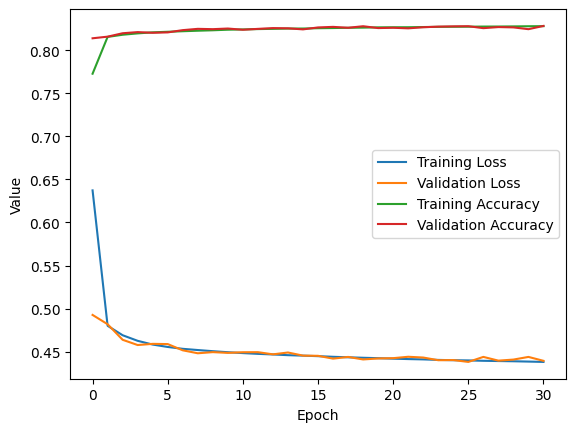

In [18]:
from keras.callbacks import EarlyStopping


# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(x_train, y_train, epochs=200, batch_size=256, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# Evaluate the trained model

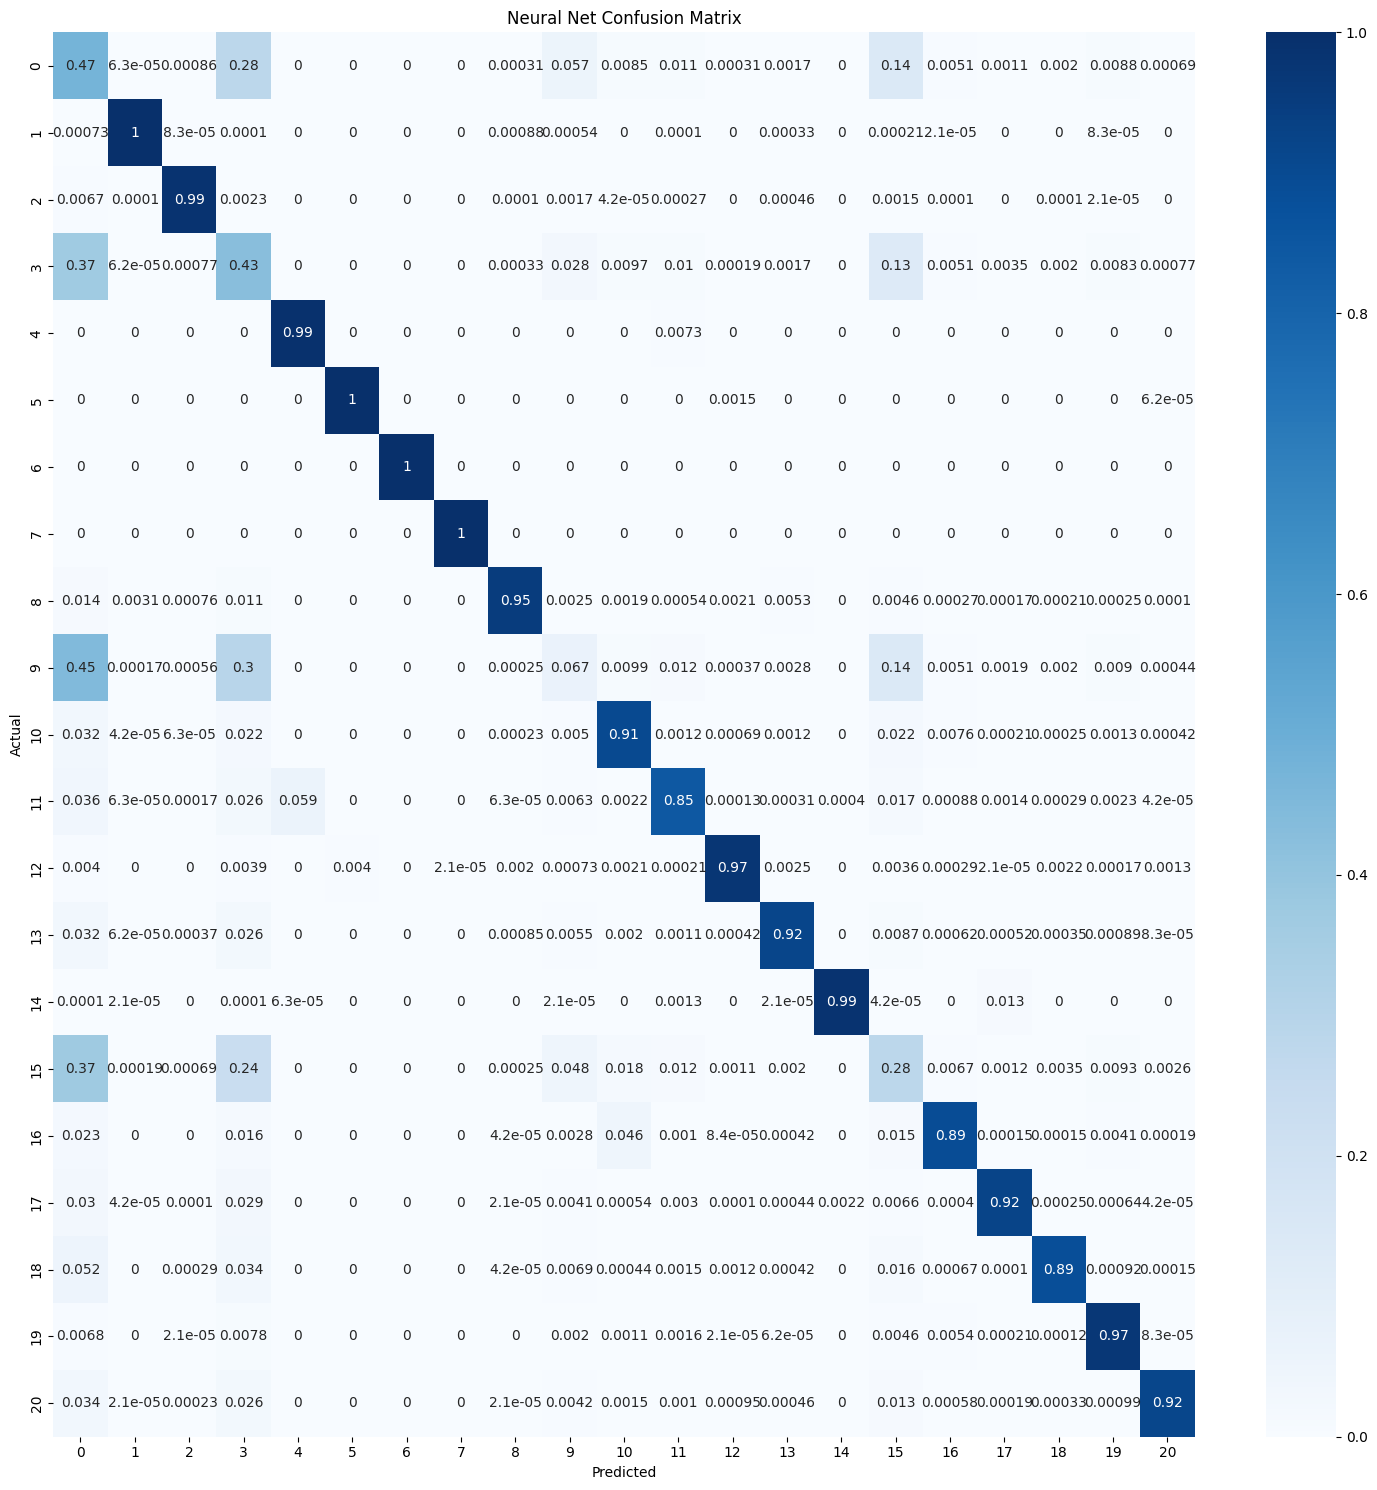

Neural Net accuracy_score: 0.8285218253968254


In [19]:

# Import the required libraries
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred,normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

y_pred = enc.inverse_transform(model.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'Neural Net Confusion Matrix')
print("Neural Net accuracy_score:", accuracy_score(y_true, y_pred))

In [23]:
model.save("nn_model")

In [35]:
df1 = pd.DataFrame(y_pred, columns=["y_pred"])
df1["y_true"] = y_true
df1.to_csv("pred")

,y_pred,y_true
0,11.0,11.0
1,12.0,12.0
2,7.0,7.0
3,3.0,9.0
4,20.0,20.0
...,...,...
1007995,16.0,16.0
1007996,7.0,7.0
1007997,4.0,4.0
1007998,17.0,17.0


In [39]:
df2 = df1[(df1.y_pred == 0) | (df1.y_pred == 1) | (df1.y_true == 0) | (df1.y_true == 1)]
len(df2)

166213

In [68]:
n = 15

len(df3)

61103

In [70]:
accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
precision = precision_score(
    y_true_filtered,
    y_pred_filtered,
    zero_division=0,
    labels=[0, n],
    pos_label=n  # Define the positive label explicitly
)
recall = recall_score(
    y_true_filtered,
    y_pred_filtered,
    zero_division=0,
    labels=[0, n],  # Specify relevant labels
    pos_label=n      # Define the positive label
)
f1 = f1_score(y_true_filtered, y_pred_filtered, zero_division=0,
    labels=[0, n],  # Specify relevant labels
    pos_label=n )
auc = roc_auc_score(y_true_filtered, y_pred_filtered) 


ValueError: pos_label=15 is not a valid label. It should be one of [0.0, 9.0]

In [67]:
print(accuracy , precision, recall , f1, auc)

0.5155463605800792 0.5415760414923875 0.130261569416499 0.21001070490154736 0.5112340932569729


In [75]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)


# Create DataFrame for analysis
df = df1

# Function to calculate G-means
def calculate_gmeans(cm):
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    return np.sqrt(sensitivity * specificity)

# Initialize result storage
results = []

# Compare each class against class '0'
for label in range(1, df1.y_pred.nunique()):
    # Binary classification: class 0 vs. class label
    df3 = df1[((df1.y_pred == 0) & (df1.y_true == 0)) |
                ((df1.y_pred == 0) & (df1.y_true == label)) |
                ((df1.y_pred == label) & (df1.y_true == 0)) |
                ((df1.y_pred == label) & (df1.y_true == label)) 
    ]
    y_true_binary = np.where(df3['y_true'] == 0, 0, np.where(df3['y_true'] == label, 1, -1))
    y_pred_binary = np.where(df3['y_pred'] == 0, 0, np.where(df3['y_pred'] == label, 1, -1))
    
    # Filter out irrelevant labels
    mask = y_true_binary != -1
    y_true_filtered = y_true_binary[mask]
    y_pred_filtered = y_pred_binary[mask]
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
    precision = precision_score(y_true_filtered, y_pred_filtered, zero_division=0)
    recall = recall_score(y_true_filtered, y_pred_filtered, zero_division=0)
    f1 = f1_score(y_true_filtered, y_pred_filtered, zero_division=0)
    auc = roc_auc_score(y_true_filtered, y_pred_filtered) if len(np.unique(y_true_filtered)) > 1 else np.nan
    
    # Confusion matrix for G-means
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=[0, 1])
    gmeans = calculate_gmeans(cm)
    
    # Append results
    results.append({
        'Comparison': f'0-{label}',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'G-Means': gmeans
    })

# Create a DataFrame for results
metrics_df = pd.DataFrame(results)

# Display the results


In [76]:
metrics_df

,Comparison,Accuracy,Precision,Recall,F1-Score,AUC,G-Means
0,0-1,0.999461,0.999937,0.999269,0.999603,0.999568,0.999568
1,0-2,0.994872,0.999132,0.993283,0.996199,0.995739,0.995736
2,0-3,0.580457,0.602906,0.537437,0.568292,0.581679,0.579994
3,0-4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0-5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0-6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,0-7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,0-8,0.989755,0.999675,0.985109,0.992338,0.992224,0.992198
8,0-9,0.515546,0.541576,0.130262,0.210011,0.511234,0.340911
9,0-10,0.971780,0.990741,0.966285,0.978360,0.974370,0.974337


In [22]:
dir(model) 

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__annotations__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_check_call_args',
 '_check_sample_weight_warning',
 '_checkpoint',
 '_checkpoi

# Realtime Fault Prediction

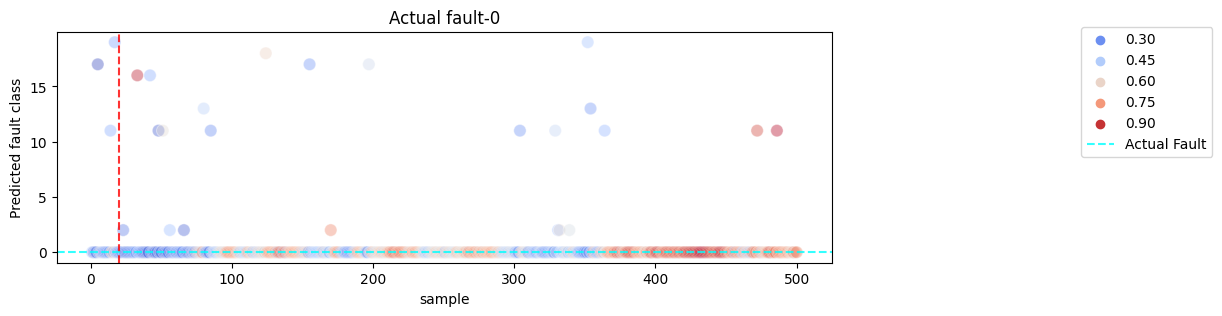

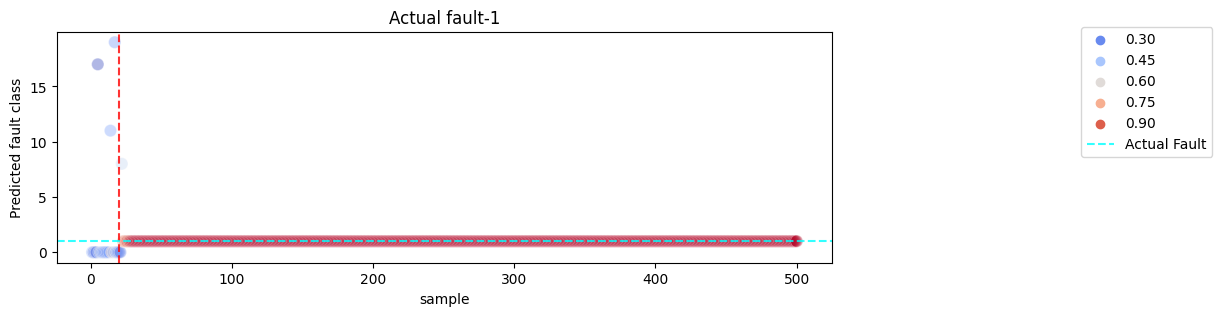

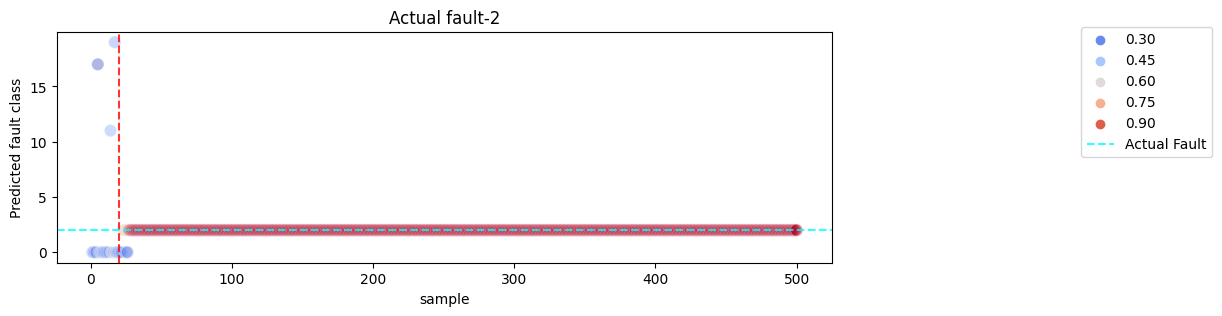

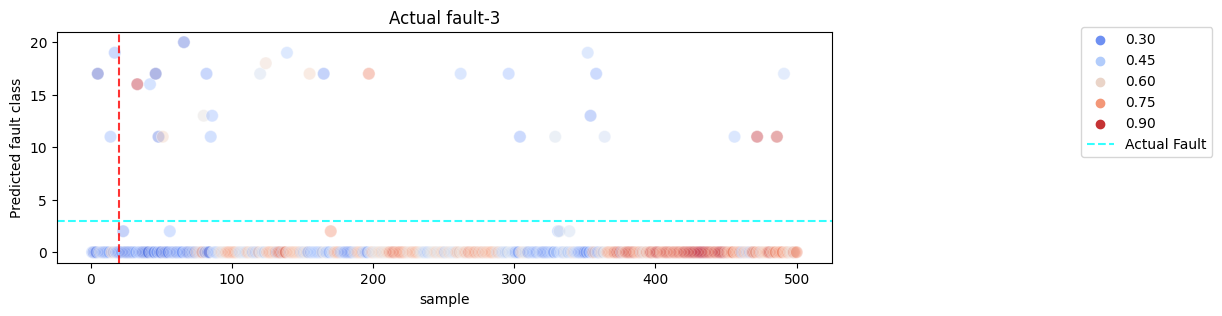

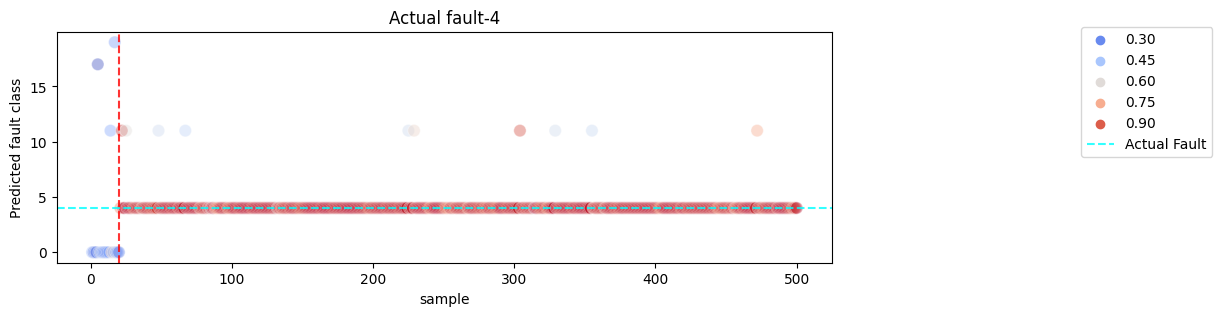

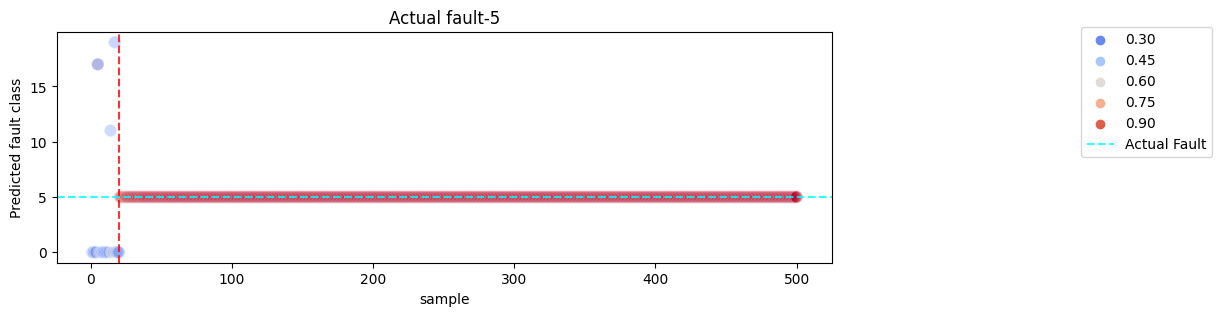

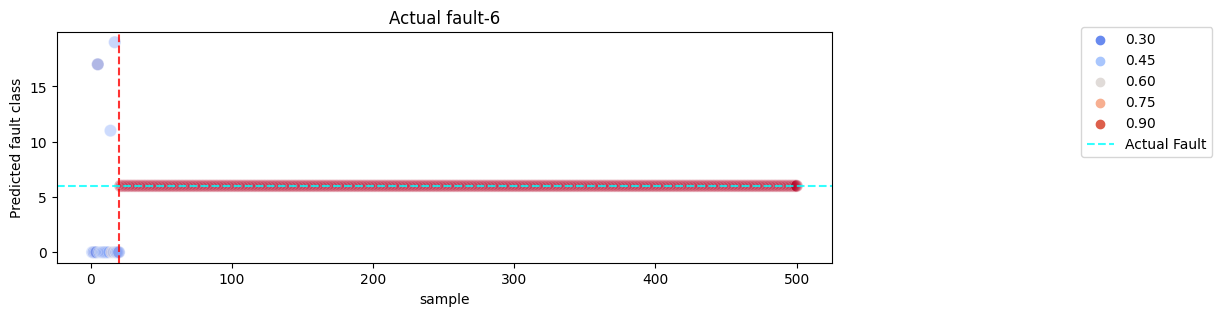

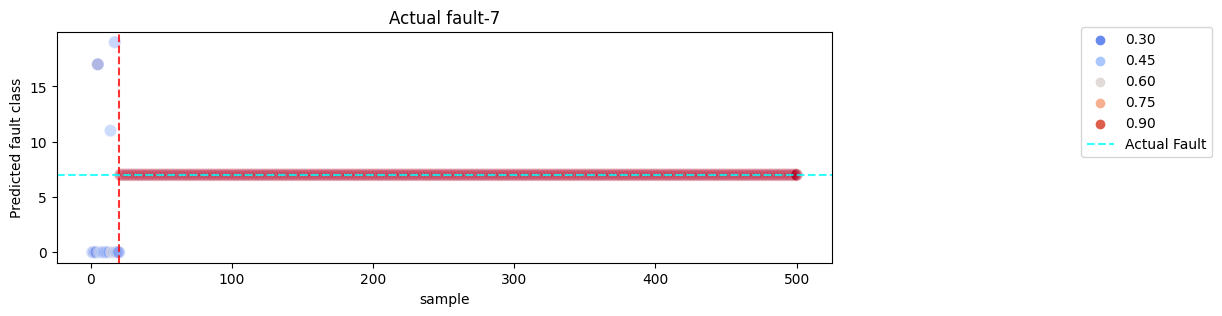

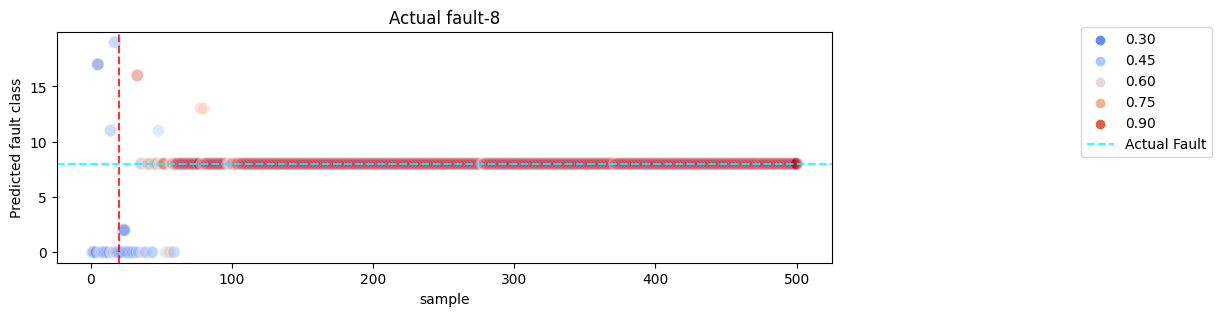

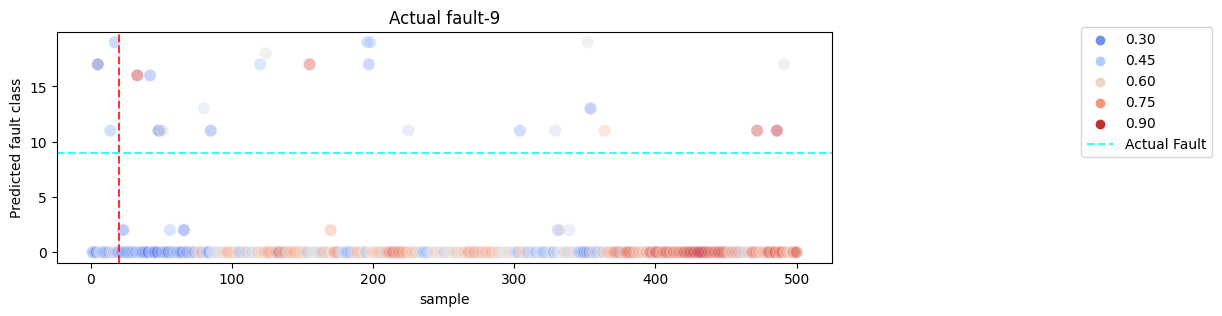

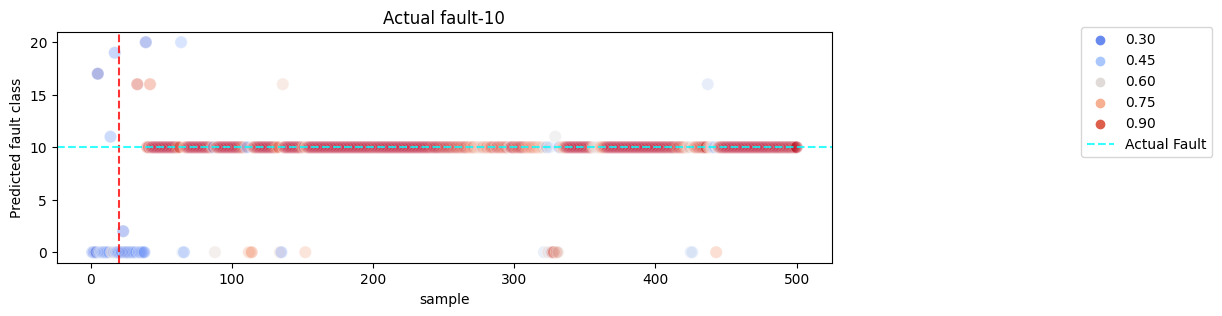

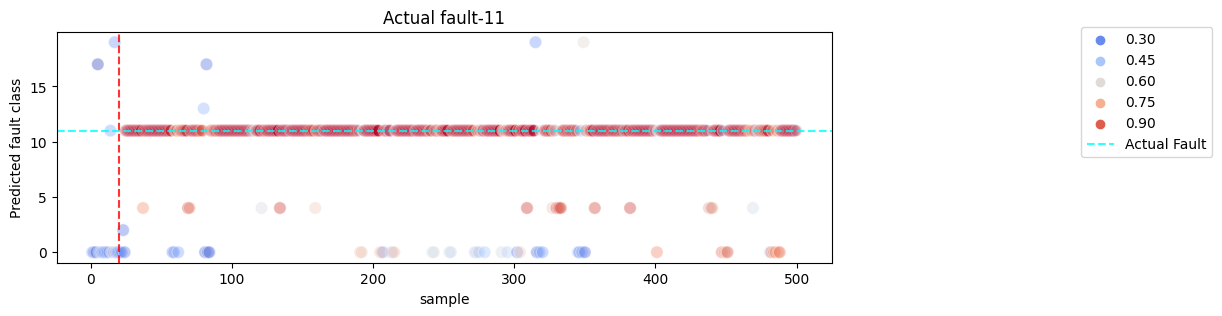

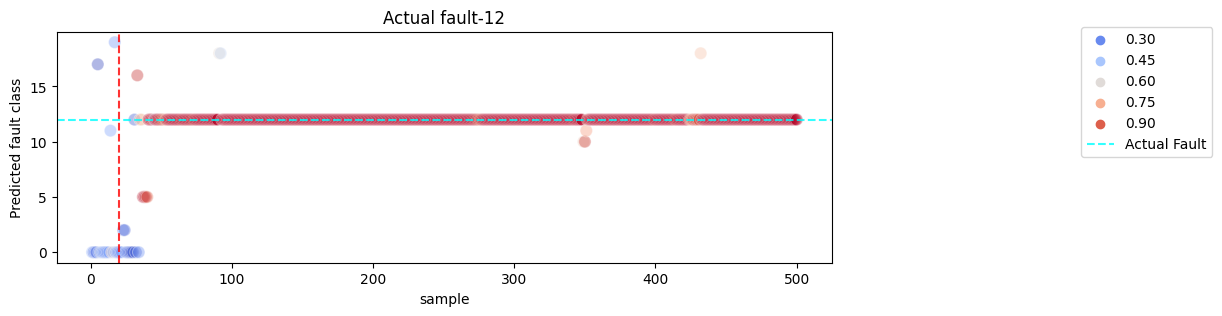

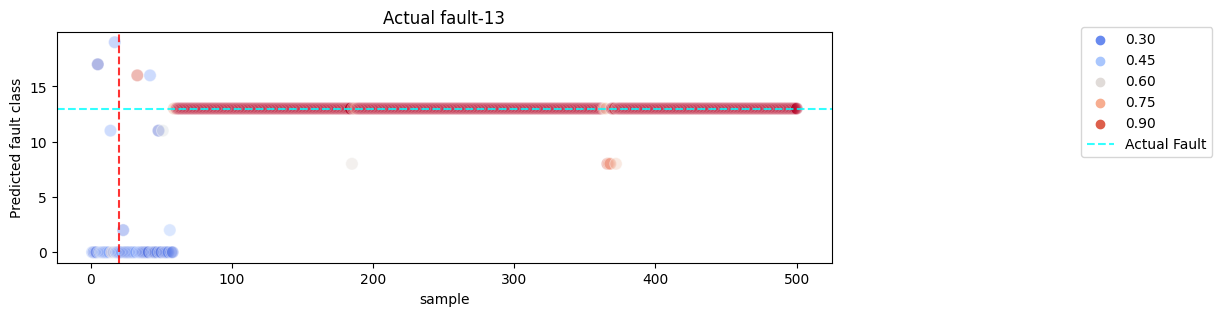

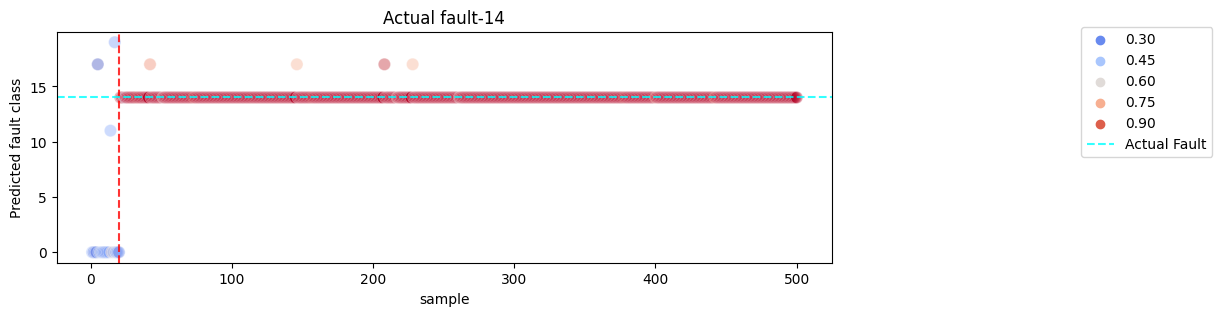

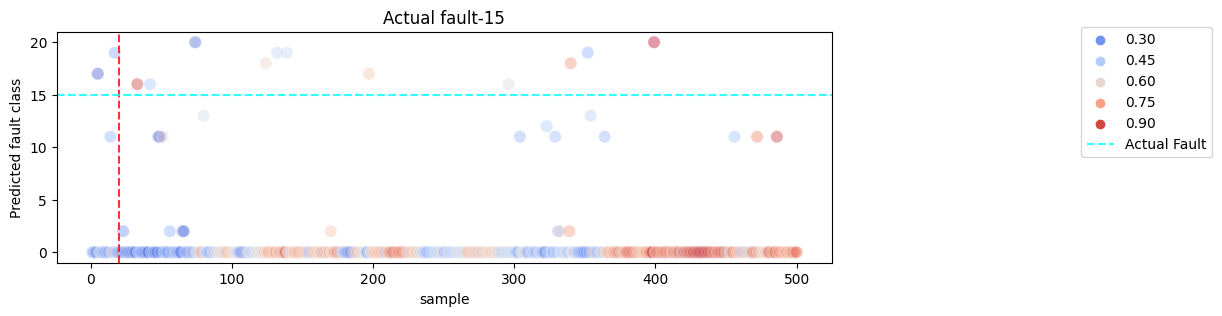

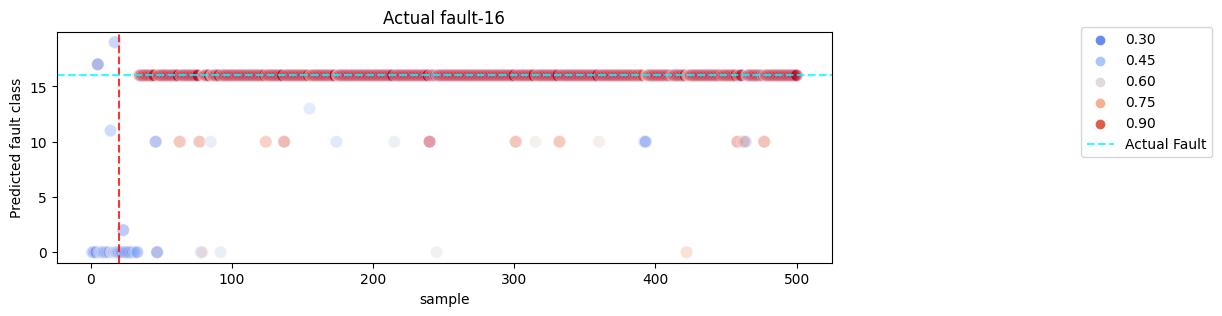

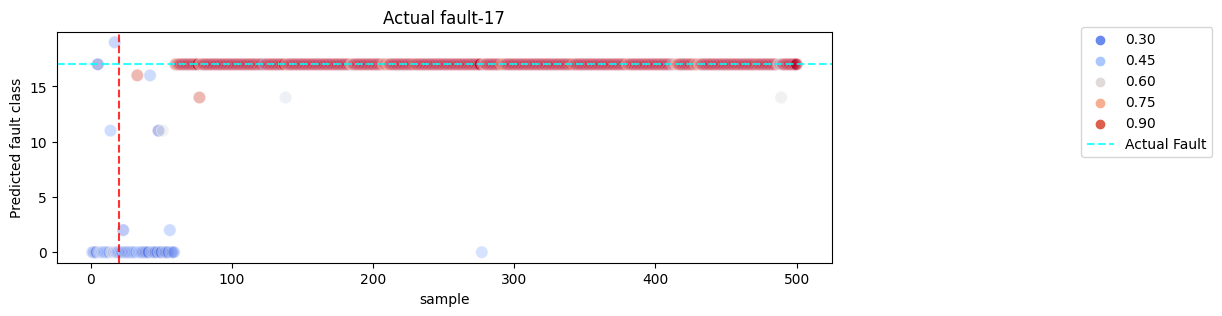

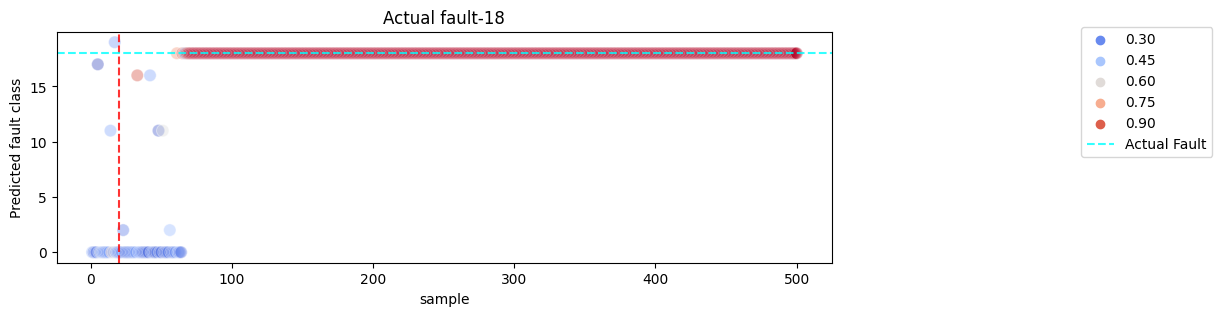

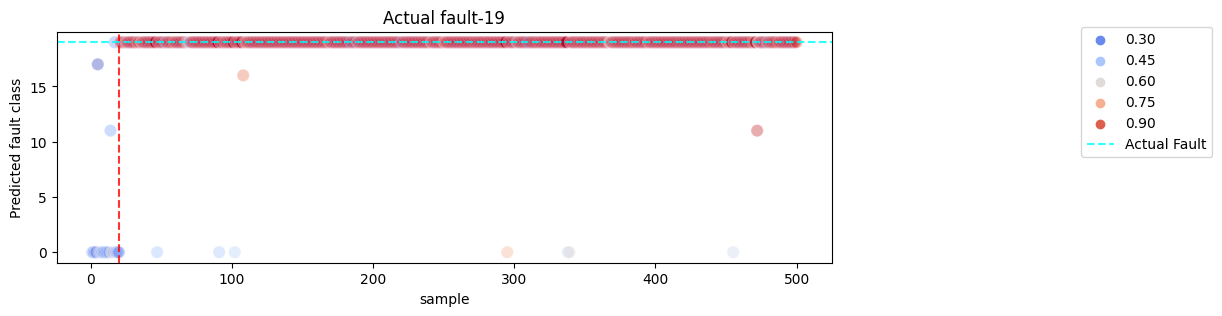

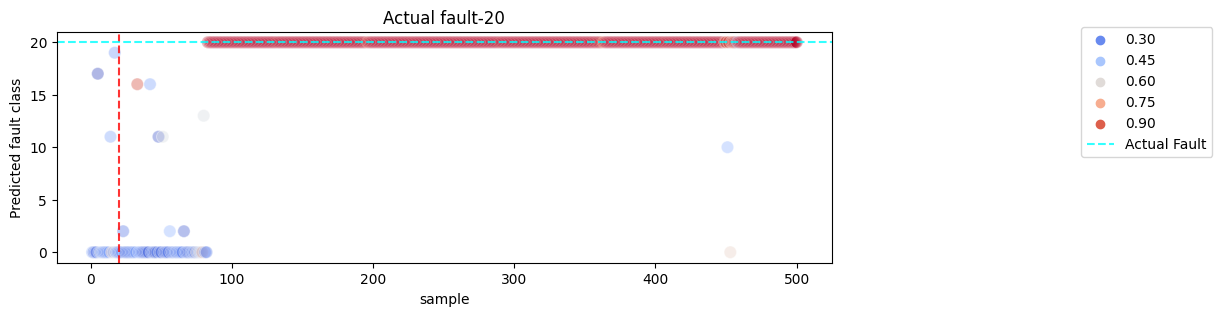

In [44]:

for F_num in range(0,21):
    df_new= df[(df['faultNumber']==F_num) & (df['simulationRun']==45)].copy()
    x_new = df_new.iloc[:,3:]
    x_new = sc.transform(x_new)

    y_pred = enc.inverse_transform(model.predict(x_new, verbose=0))
    y_proba = np.max(model.predict(x_new, verbose=0),axis=1)

    f, ax = plt.subplots(figsize=(10,3))
    
    sns.scatterplot(x=df_new['sample'],y=y_pred[:,0],hue=y_proba,palette="coolwarm",s=80,alpha=0.4)
    
    plt.axvline(20,c='r',alpha=0.8,linestyle ='--')
    plt.axhline(F_num,c='cyan',alpha=0.8,label='Actual Fault',linestyle ='--')
    plt.legend(bbox_to_anchor=(1.5, 1.05))
    plt.ylabel('Predicted fault class')
    plt.title(f'Actual fault-{F_num}')
    plt.show()

In [45]:

y_label = enc.inverse_transform(y_train[::50,:]).reshape(-1)


In [46]:
y_train[::50].shape

(69120, 18)

In [47]:
enc.inverse_transform(y_train[::50,:]).reshape(-1).shape

(69120,)

In [48]:
x_train[::50].shape

(69120, 52)

# tsne

In [1]:
x_embedded = TSNE_GPU(n_components=2, learning_rate=20, perplexity=25).fit_transform(x_train[::50,:])
y_label = enc.inverse_transform(y_train[::50,:]).reshape(-1)

# Create a scatter plot of the embedded data, colored by the true labels
f, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=x_embedded[:,0],y=x_embedded[:,1],hue=y_label,style=y_label,palette="bright",edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('After training')
plt.show()

NameError: name 'TSNE_GPU' is not defined

In [2]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model("/kaggle/working/NNmodel")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


OSError: No file or directory found at /kaggle/working/NNmodel

In [ ]:
import h5py
import numpy as np
with h5py.File("/kaggle/working/train_data.h5", "r") as hdf_file:
    # Access the datasets
    x_train = np.array(hdf_file["x_train"])
    y_train = np.array(hdf_file["y_train"])

In [ ]:
from tensorflow.keras import Model

intermediate_model = Model(inputs=model.input,outputs=model.layers[-2].output)
intermediate_model.summary()

In [ ]:
from tsnecuda import TSNE as TSNE_GPU
x_inter = intermediate_model.predict(x_train)

In [ ]:
x_embedded = TSNE_GPU(n_components=2, learning_rate=20, perplexity=25).fit_transform(x_train)

In [ ]:
y_label = enc.inverse_transform(y_train).reshape(-1)

In [ ]:
# Create a scatter plot of the embedded data, colored by the true labels
f, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=x_embedded[:,0],y=x_embedded[:,1],hue=y_label,style=y_label,palette="bright",edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('After training')
plt.show()

In [ ]:
model.save("NNmodel")

## Shap explainer

In [ ]:
import shap
shap.initjs()

In [ ]:
y_pred.flatten().shape

In [ ]:
def f(X):
    return enc.inverse_transform(loaded_model.predict(X, verbose=0)).flatten()

In [ ]:
explainer = shap.Explainer(loaded_model, x_train[::200])

# Calculate SHAP values for the input data
shap_values = explainer.shap_values(x_test[::50])

In [ ]:
shap.summary_plot(shap_values, x_test[::50], feature_names=df.columns[3:], max_display=10, plot_type="bar", class_names=[f"class:{i}" for i in range(0,18)])

In [ ]:
shap.summary_plot(shap_values, x_test[::50], max_display=15)

In [ ]:
dir(shap)